<a href="https://colab.research.google.com/github/harmanpreet93/reinforcement-learning-COMP-767/blob/master/Q_learning_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
import gym
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.autograd import Variable
from IPython.display import clear_output

# ! pip install tensorflow==2.1.0
import tensorflow as tf
tf.__version__

'2.1.0'

In [0]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [268]:
env = gym.make('CartPole-v1')
env.reset()

discount_rate = 0.9
epsilon = 0.1
step_size = 0.1 # learning rate
n_obs_space = len(env.observation_space.high)
n_actions = env.action_space.n

n_hidden = 64

class Model(tf.keras.Model):

    def __init__(self, n_states, n_actions, hidden_dim=64, lr=0.05):
        super(Model, self).__init__()
        self.dense1 = tf.keras.layers.Dense(n_hidden, input_shape=(n_states,), activation='relu')
        self.dense2 = tf.keras.layers.Dense(n_hidden, activation='relu')
        self.logits = tf.keras.layers.Dense(n_actions)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.logits(x)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss_fn = tf.keras.losses.MeanSquaredError()
train_loss = tf.keras.metrics.MeanSquaredError()
train_accuracy = tf.keras.metrics.Accuracy()

@tf.function
def train_step(inputs, y_true, optimizer, loss_fn):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        y_pred = model(inputs, training=True)
        loss = loss_fn(y_true, y_pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return y_pred, y_true, loss

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
def replay(model, memory, buffer_size, discount_rate, optimizer, loss_fn):
    if len(memory) > buffer_size:
        X,y = [], []
        # sample batch from memory
        memory_batch = random.sample(memory, buffer_size)
        for current_state, action, next_state, reward, done in memory_batch:
            X.append(current_state)
            input_vector = np.reshape(current_state, (1,*current_state.shape))
            q_values = model(input_vector).numpy()[0]
            if done:
                q_values[action] = reward
            else:
                input_vector = np.reshape(next_state, (1,*next_state.shape))
                q_values_next = model(input_vector)
                print(q_values_next)
                q_values[action] = reward + discount_rate * np.max(q_values_next)
            y.append(q_values)

        X = np.array(X)
        y = np.array(y)
        dataset = tf.data.Dataset.from_tensor_slices((X,y)).batch(1)
        
        # train model here
        train_step(X, y, optimizer, loss_fn)

        n_epochs = 10
        for epoch in range(n_epochs):

            for minibatch in dataset:
                train_step(minibatch[0], minibatch[-1], optimizer, loss_fn)

                train_loss(loss)
                train_accuracy(y_true, y_pred)

                template = 'Episode {}, Loss: {}, Accuracy: {}'
                print(template.format(episode+1,
                                train_loss.result(),
                                train_accuracy.result()*100))

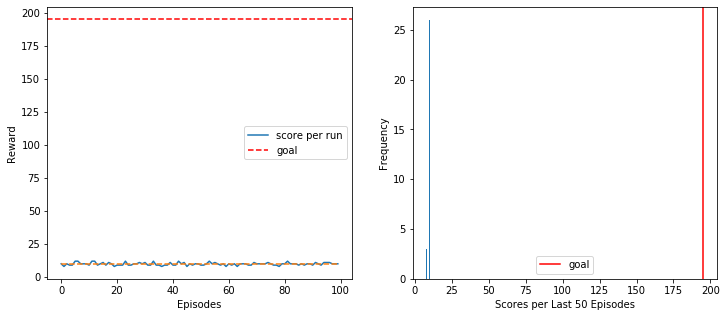

In [276]:
model = Model(n_obs_space, n_actions, hidden_dim=64)

n_episodes = 100
replay_buffer_size = 20
memory = []
reward_list = []
memory_index = 0

for episode in range(n_episodes):
    train_loss.reset_states()
    train_accuracy.reset_states()

    done = False
    current_state = env.reset()
    total_reward = 0
    memory = []

    while not done:
        # choose action based on epsilon-greedy policy
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            input_vector = np.reshape(state, (1,*state.shape))
            Q_output = model(input_vector)
            action = np.argmax(Q_output)

        # take chosen action
        next_state, reward, done, info = env.step(action)
        # add reward
        total_reward += reward

        # save states and action in memory
        memory.append((current_state, action, next_state, reward, done))

        if done:
            break
        
        replay(model, memory, replay_buffer_size, discount_rate, optimizer, loss_fn)
        current_state = next_state

    reward_list.append(total_reward)
    plot_res(reward_list)

In [0]:
plot_res(reward_list)

In [170]:
y[0], model(np.reshape(X[0], (1,*X[0].shape)))

(array([5.2412195, 6.847495 ], dtype=float32),
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[5.250276, 6.652201]], dtype=float32)>)

In [107]:
print(train_X.shape, train_y.shape)

(98, 4) (98, 2)


In [0]:
import torch

In [0]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, state, y):
            """Update the weights of the network given a training sample. """
            y_pred = self.model(torch.Tensor(state))
            loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
    def predict(self, state):
            """ Compute Q values for all actions using the DQL. """
            with torch.no_grad():
                return self.model(torch.Tensor(state))

In [0]:
def q_learning(env, model, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQL', double=False, 
               n_update=10, soft=False):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    for episode in range(episodes):
        # Reset state
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                break

            # Update network weights using replay memory
            model.replay(memory, replay_size, gamma)
            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
    return final

In [0]:
# Expand DQL class with a replay function.
class DQN_replay(DQN):
    def replay(self, memory, size, gamma=0.9):
        """ Add experience replay to the DQN network class. """
        # Make sure the memory is big enough
        if len(memory) >= size:
            states = []
            targets = []
            # Sample a batch of experiences from the agent's memory
            batch = random.sample(memory, size)
            
            # Extract information from the data
            for state, action, next_state, reward, done in batch:
                states.append(state)
                # Predict q_values
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:
                    q_values_next = self.predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)

            self.update(states, targets)

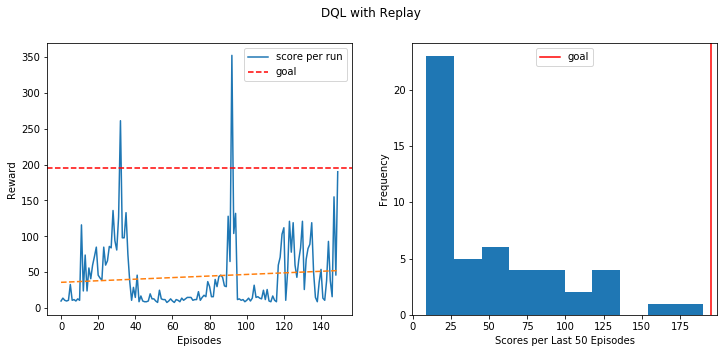

In [281]:
# Get replay results
dqn_replay = DQN_replay(n_obs_space, n_actions, n_hidden, lr=0.05)

replay = q_learning(env, dqn_replay, 
                    episodes=150, gamma=.9, 
                    epsilon=0.2, replay=True, 
                    title='DQL with Replay')